### Goal: Join all of the fetal single nucleus RNA-seq datasets

The goal of this script is to join all of the external datasets and internal snRNA-seq datasets together. We will not include single cell datasets as they have significantly different transcript composition than nuclear data.

In each of their individual directories, we examined the processed data of each publication using a simple scanpy preprocessing procedure with Harmony integration. As the batch effects are quite significant between different datasets, we will use scVI integration eventually to harmonize the UMAP embedding.

We will combine the following datasets:
1. Penn internal 
2. ENCODE v4 (Snyder), unpublished
3. Sim et al. 2020

### Consistent metadata across studies

We will keep the follow metadata (per cell) from each of the datasets

1. Donor id
2. Donor age
3. Donor sex
4. Disease
5. Technology used for library generation 
6. Cell or nuclei (should all be nuclei only)
7. Region (e.g. chamber such as LV)
8. Study
9. cell_type annotation (original annotation from each study, or our annotations for Penn and ENCODE v4 dataset)
10. consistent_cell_type (annotation from each study, but made consistent across all studies)

#### Import libraries

In [1]:
import scanpy as sc
import anndata as adata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import anndata as ad
from collections import Counter
import seaborn as sns
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import re
import gc
from adjustText import adjust_text
from sklearn.mixture import GaussianMixture

In [2]:
metadata_to_keep = ["age", 
                    "donor_id", 
                    "sex", 
                    "region", 
                    "cell_type",
                    "disease",
                    "consistent_cell_type",
                    "study", 
                    "technology", 
                    "cell_or_nuclei"]

### Sequentially load each of the datasets 
1. Confirm that the counts are the RAW counts (not normalized)

In [3]:
def confirm_raw_counts(adata):
    """
    Check if every value in adata.X.sum(axis=1), the sum of counts across all genes per cell, is an integer.   

    Parameters:
    adata (AnnData): The AnnData object containing the data matrix (adata.X).

    Returns:
    bool: True if all sums are integers, False otherwise.
    """
    # Sum across rows (axis=1), which correspond to the genes
    sums = adata.X.sum(axis=1)
    
    # Check if all sums are integers by comparing them to their rounded versions
    return np.all(np.equal(sums, np.round(sums)))

#### Penn dataset

In [4]:
%%time
Penn_adata = sc.read_h5ad("../internal_datasets/fetal_datasets/combined_analysis/03_processed_Penn_fetal.h5ad")
Penn_adata.X = Penn_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Penn_adata)) )

# include sample_id
Penn_adata.obs = Penn_adata.obs[metadata_to_keep + ["sample_id"]]

All raw counts?: True
CPU times: user 456 ms, sys: 716 ms, total: 1.17 s
Wall time: 1.17 s


In [5]:
Penn_adata.obs_names

Index(['Fetal-1st-LV-0315-2-run1n2:AAAAAAACTGGC',
       'Fetal-1st-LV-0315-2-run1n2:AAAAAAGCCCCT',
       'Fetal-1st-LV-0315-2-run1n2:AAAAAAGGGCGG',
       'Fetal-1st-LV-0315-2-run1n2:AAAAAGAAATCC',
       'Fetal-1st-LV-0315-2-run1n2:AAAAAGACTCTT',
       'Fetal-1st-LV-0315-2-run1n2:AAAAAGGGCTTA',
       'Fetal-1st-LV-0315-2-run1n2:AAAAAGTTTTAA',
       'Fetal-1st-LV-0315-2-run1n2:AAAACGATTTCT',
       'Fetal-1st-LV-0315-2-run1n2:AAAACGCGAAGC',
       'Fetal-1st-LV-0315-2-run1n2:AAAACTAGCAAT',
       ...
       'Fetal-2nd-OFT-2:TTTTGTCCGCCC', 'Fetal-2nd-OFT-2:TTTTGTTTACAC',
       'Fetal-2nd-OFT-2:TTTTTAAGTGAG', 'Fetal-2nd-OFT-2:TTTTTACATAAA',
       'Fetal-2nd-OFT-2:TTTTTACTATCT', 'Fetal-2nd-OFT-2:TTTTTAGTAGCT',
       'Fetal-2nd-OFT-2:TTTTTATGGGTG', 'Fetal-2nd-OFT-2:TTTTTGCTTCTG',
       'Fetal-2nd-OFT-2:TTTTTGGTTCAG', 'Fetal-2nd-OFT-2:TTTTTTGACTTG'],
      dtype='object', name='index', length=53696)

In [6]:
Penn_adata.obs['barcode'] = Penn_adata.obs_names.str.split(":").str[-1]

In [7]:
Penn_adata.obs_names = Penn_adata.obs['sample_id'].astype(str) + ":" + Penn_adata.obs['barcode'].astype(str)

In [8]:
Counter(Penn_adata.obs_names).most_common()[0]

('Fetal-1st-LV-0315-2-run1n2:AAAAAAACTGGC', 1)

In [9]:
Penn_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode
Fetal-1st-LV-0315-2-run1n2:AAAAAAACTGGC,18,Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,Nuclei,Fetal-1st-LV-0315-2-run1n2,AAAAAAACTGGC
Fetal-1st-LV-0315-2-run1n2:AAAAAAGCCCCT,18,Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,Nuclei,Fetal-1st-LV-0315-2-run1n2,AAAAAAGCCCCT
Fetal-1st-LV-0315-2-run1n2:AAAAAAGGGCGG,18,Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,Nuclei,Fetal-1st-LV-0315-2-run1n2,AAAAAAGGGCGG
Fetal-1st-LV-0315-2-run1n2:AAAAAGAAATCC,18,Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,Nuclei,Fetal-1st-LV-0315-2-run1n2,AAAAAGAAATCC
Fetal-1st-LV-0315-2-run1n2:AAAAAGACTCTT,18,Penn_F1,female,LV,Endothelial,ND,Endothelial,Penn,Dropseq,Nuclei,Fetal-1st-LV-0315-2-run1n2,AAAAAGACTCTT


In [10]:
Counter(Penn_adata.obs.region)

Counter({'LV': 20641, 'OFT': 14613, 'Atria': 14423, 'LRV': 4019})

#### ENCODE v4 (Snyder Lab)

In [11]:
%%time
ENCODE_adata = sc.read_h5ad("../external_datasets/fetal_datasets/ENCODE_v4/03_reformatted_ENCODE_fetal.h5ad")
ENCODE_adata.X = ENCODE_adata.layers['counts']
ENCODE_adata.obs['disease'] = "ND"
print("All raw counts?: " + str (confirm_raw_counts(ENCODE_adata)) )
ENCODE_adata.obs = ENCODE_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 803 ms, sys: 1.48 s, total: 2.28 s
Wall time: 2.28 s


In [12]:
ENCODE_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei
index,,,,,,,,,,
ENCFF802AQC:AAACAGCCAAGCTACC,13.0,ENCFF802AQC,male,WH,Cardiomyocyte,ND,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCFF802AQC:AAACAGCCACATTGCA,13.0,ENCFF802AQC,male,WH,Neuronal,ND,Neuronal,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCFF802AQC:AAACATGCAATCCCTT,13.0,ENCFF802AQC,male,WH,Endocardial,ND,Endocardial,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCFF802AQC:AAACATGCAGCAACAG,13.0,ENCFF802AQC,male,WH,Cardiomyocyte,ND,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCFF802AQC:AAACATGCAGGCGAGT,13.0,ENCFF802AQC,male,WH,Endocardial,ND,Endocardial,ENCODE v4 (Snyder),Multiome-v1,Nuclei


In [13]:
ENCODE_adata.obs['barcode'] = ENCODE_adata.obs_names.str.split(":").str[-1]
ENCODE_adata.obs['sample_id'] = ENCODE_adata.obs['donor_id']

In [14]:
Counter(ENCODE_adata.obs_names).most_common()[0]

('ENCFF802AQC:AAACAGCCAAGCTACC', 1)

In [15]:
ENCODE_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
index,,,,,,,,,,,,
ENCFF802AQC:AAACAGCCAAGCTACC,13.0,ENCFF802AQC,male,WH,Cardiomyocyte,ND,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei,AAACAGCCAAGCTACC,ENCFF802AQC
ENCFF802AQC:AAACAGCCACATTGCA,13.0,ENCFF802AQC,male,WH,Neuronal,ND,Neuronal,ENCODE v4 (Snyder),Multiome-v1,Nuclei,AAACAGCCACATTGCA,ENCFF802AQC
ENCFF802AQC:AAACATGCAATCCCTT,13.0,ENCFF802AQC,male,WH,Endocardial,ND,Endocardial,ENCODE v4 (Snyder),Multiome-v1,Nuclei,AAACATGCAATCCCTT,ENCFF802AQC
ENCFF802AQC:AAACATGCAGCAACAG,13.0,ENCFF802AQC,male,WH,Cardiomyocyte,ND,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei,AAACATGCAGCAACAG,ENCFF802AQC
ENCFF802AQC:AAACATGCAGGCGAGT,13.0,ENCFF802AQC,male,WH,Endocardial,ND,Endocardial,ENCODE v4 (Snyder),Multiome-v1,Nuclei,AAACATGCAGGCGAGT,ENCFF802AQC


#### Sim et al. 2020 (Porello Lab)

In [16]:
%%time
# read in the entire dataset
Sim_adata = sc.read_h5ad("../external_datasets/fetal_datasets/Sim_et_al_2020/02_Sim_fetal.h5ad")
Sim_adata.X = Sim_adata.layers['counts']
Sim_adata.obs['disease'] = "ND"
print("All raw counts?: " + str (confirm_raw_counts(Sim_adata)) )
Sim_adata.obs = Sim_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 476 ms, sys: 857 ms, total: 1.33 s
Wall time: 1.33 s


In [17]:
Sim_adata.obs['barcode'] = Sim_adata.obs_names.str.split(":").str[-1]
Sim_adata.obs['sample_id'] = Sim_adata.obs['donor_id']

In [18]:
Counter(Sim_adata.obs_names).most_common(1)[0]

('GSM4742858_Fetal2_processed:AAACCCAAGGCATCGA-1', 1)

In [19]:
Sim_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
GSM4742858_Fetal2_processed:AAACCCAAGGCATCGA-1,19,GSM4742858_Fetal2_processed,male,LV,Cardiomyocyte,ND,Cardiomyocyte,Sim 2021,3prime-v1,Nuclei,AAACCCAAGGCATCGA-1,GSM4742858_Fetal2_processed
GSM4742858_Fetal2_processed:AAACCCAAGGTAGGCT-1,19,GSM4742858_Fetal2_processed,male,LV,Cardiomyocyte,ND,Cardiomyocyte,Sim 2021,3prime-v1,Nuclei,AAACCCAAGGTAGGCT-1,GSM4742858_Fetal2_processed
GSM4742858_Fetal2_processed:AAACCCAAGTCAATCC-1,19,GSM4742858_Fetal2_processed,male,LV,Cardiomyocyte,ND,Cardiomyocyte,Sim 2021,3prime-v1,Nuclei,AAACCCAAGTCAATCC-1,GSM4742858_Fetal2_processed
GSM4742858_Fetal2_processed:AAACCCAAGTGGCAGT-1,19,GSM4742858_Fetal2_processed,male,LV,Cardiomyocyte,ND,Cardiomyocyte,Sim 2021,3prime-v1,Nuclei,AAACCCAAGTGGCAGT-1,GSM4742858_Fetal2_processed
GSM4742858_Fetal2_processed:AAACCCACAAAGCTAA-1,19,GSM4742858_Fetal2_processed,male,LV,Cardiomyocyte,ND,Cardiomyocyte,Sim 2021,3prime-v1,Nuclei,AAACCCACAAAGCTAA-1,GSM4742858_Fetal2_processed


### Combine together

In [20]:
# run this so that adata won't complain
def convert_indices_to_string(adata):
    adata.obs.index = adata.obs.index.astype(str)
    adata.var.index = adata.var.index.astype(str)
    return adata

In [21]:
# Convert indices for all adata
Penn_adata = convert_indices_to_string(Penn_adata)
ENCODE_adata = convert_indices_to_string(ENCODE_adata)
Sim_adata = convert_indices_to_string(Sim_adata)

The inner join for features (genes), rather than outer join is more appropriate as many of the datasets removed mitochondrial transcripts entirely from their analysis.

In [24]:
# merge the adata together
all_adata = ad.concat([Penn_adata,
                       ENCODE_adata,
                       Sim_adata])
all_adata

AnnData object with n_obs × n_vars = 150161 × 19214
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'sample_id', 'barcode'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'

In [25]:
all_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode
Fetal-1st-LV-0315-2-run1n2:AAAAAAACTGGC,18.0,Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,Nuclei,Fetal-1st-LV-0315-2-run1n2,AAAAAAACTGGC
Fetal-1st-LV-0315-2-run1n2:AAAAAAGCCCCT,18.0,Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,Nuclei,Fetal-1st-LV-0315-2-run1n2,AAAAAAGCCCCT
Fetal-1st-LV-0315-2-run1n2:AAAAAAGGGCGG,18.0,Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,Nuclei,Fetal-1st-LV-0315-2-run1n2,AAAAAAGGGCGG
Fetal-1st-LV-0315-2-run1n2:AAAAAGAAATCC,18.0,Penn_F1,female,LV,Cardiomyocyte,ND,Cardiomyocyte,Penn,Dropseq,Nuclei,Fetal-1st-LV-0315-2-run1n2,AAAAAGAAATCC
Fetal-1st-LV-0315-2-run1n2:AAAAAGACTCTT,18.0,Penn_F1,female,LV,Endothelial,ND,Endothelial,Penn,Dropseq,Nuclei,Fetal-1st-LV-0315-2-run1n2,AAAAAGACTCTT


In [26]:
Counter(all_adata.obs_names).most_common()[0]

('Fetal-1st-LV-0315-2-run1n2:AAAAAAACTGGC', 1)

### Visualize metadata about the datasets

This is also a way to check that the metadata is consistent

#### Age representation across all datasets

In [27]:
donor_information = ( all_adata.obs.reset_index(drop = True)[["sex", "donor_id", "age", "study", "technology"]]
                     .drop_duplicates()
                     .reset_index(drop = True) )
donor_information

,sex,donor_id,age,study,technology
0,female,Penn_F1,18.0,Penn,Dropseq
1,male,Penn_F2,18.0,Penn,Dropseq
2,male,ENCFF802AQC,13.0,ENCODE v4 (Snyder),Multiome-v1
3,male,ENCFF248EWR,15.0,ENCODE v4 (Snyder),Multiome-v1
4,female,ENCFF849ALE,16.0,ENCODE v4 (Snyder),Multiome-v1
5,female,ENCFF775ANN,15.0,ENCODE v4 (Snyder),Multiome-v1
6,female,ENCFF805YRY,18.0,ENCODE v4 (Snyder),Multiome-v1
7,female,ENCFF727JRO,17.0,ENCODE v4 (Snyder),Multiome-v1
8,female,ENCFF776DQR,12.0,ENCODE v4 (Snyder),Multiome-v1
9,female,ENCFF684YRB,10.0,ENCODE v4 (Snyder),Multiome-v1


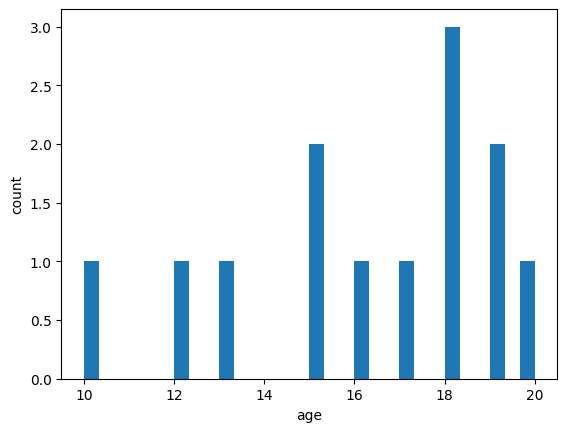

In [28]:
plt.hist(donor_information['age'], bins = 30)
plt.xlabel("age")
plt.ylabel("count")
plt.show()

In [29]:
donor_information['study'] = pd.Categorical(donor_information['study'])
donor_information['technology'] = pd.Categorical(donor_information['technology'])
donor_information['sex'] = pd.Categorical(donor_information['sex'])

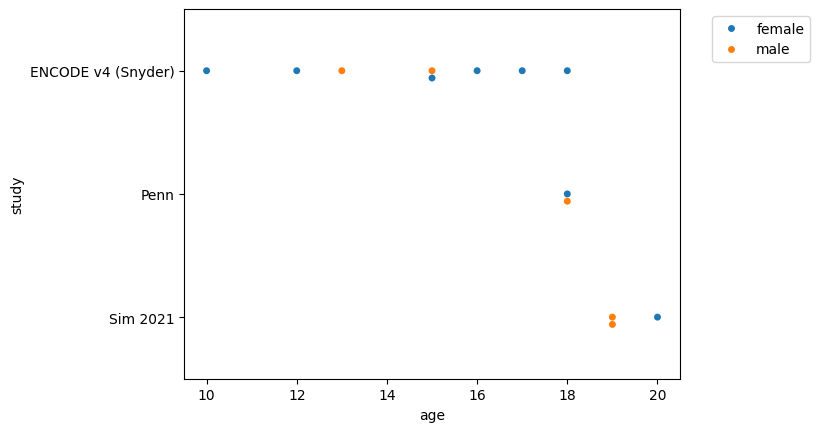

In [30]:
sns.swarmplot(data = donor_information, x='age', y='study', hue = 'sex', alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Examine sex-specific expression
Based on the analysis of some sex-specific genes

In [31]:
metadata_at_donor_level = all_adata.obs.reset_index(drop = True)[["age", "sex", "donor_id"]].drop_duplicates()

# pseudobulk
pseudobulked_adata = sc.get.aggregate(all_adata, by=["donor_id"], func="sum")
pseudobulked_adata.X = pseudobulked_adata.layers['sum']

In [32]:
# These are genes that have strong sex-specific expression
female_sex_specific_genes = ['TSIX', 'XIST']
male_sex_specific_genes = ['DDX3Y', 'EIF1AY', 'KDM5D', 'LINC00278', 'RPS4Y1',
                             'TMSB4Y', 'TTTY10', 'TTTY14', 'USP9Y', 'UTY', 'ZFY', 'ZFY-AS1']
combined_sex_specific_genes = female_sex_specific_genes + male_sex_specific_genes

In [33]:
pseudobulked_adata.X = pseudobulked_adata.layers['sum']

In [34]:
sex_specific_pseudobulked_adata = pseudobulked_adata[:, pseudobulked_adata.var.index.isin(combined_sex_specific_genes)]
sex_specific_pseudobulked_adata.X = sex_specific_pseudobulked_adata.layers['sum']

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


In [35]:
%%time
sc.pp.normalize_total(sex_specific_pseudobulked_adata)
sc.pp.log1p(sex_specific_pseudobulked_adata)
sc.pp.scale(sex_specific_pseudobulked_adata)
sc.pp.highly_variable_genes(sex_specific_pseudobulked_adata, n_top_genes=100)
sc.tl.pca(sex_specific_pseudobulked_adata)

CPU times: user 32.2 ms, sys: 4.18 ms, total: 36.4 ms
Wall time: 34.7 ms


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [36]:
# add more metadata to the pseudobulked metadata
sex_specific_pseudobulked_adata.obs = sex_specific_pseudobulked_adata.obs.merge(metadata_at_donor_level, on = "donor_id", how = "inner")

#### Visualize PCA clusters in easier to edit format

In [37]:
pseudobulked_metadata = sex_specific_pseudobulked_adata.obs

In [38]:
pseudobulked_metadata['PC1'] = sex_specific_pseudobulked_adata.obsm['X_pca'][:, 0]
pseudobulked_metadata['PC2'] = sex_specific_pseudobulked_adata.obsm['X_pca'][:, 1]

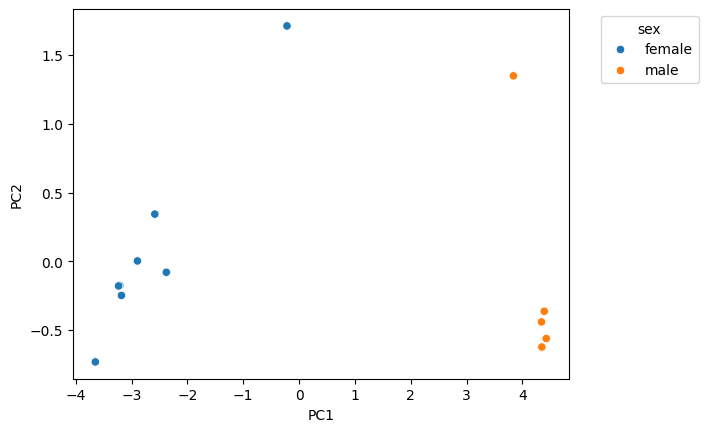

In [39]:
sns.scatterplot(data = pseudobulked_metadata,
                x = "PC1", y = "PC2", hue = "sex")
plt.legend(title='sex', bbox_to_anchor=(1.05, 1), loc='upper left')

In [40]:
likely_misclassified_female_donors = pseudobulked_metadata[(pseudobulked_metadata['PC1'] < 0) & (pseudobulked_metadata['sex'] == "male")].donor_id
likely_misclassified_female_donors

Series([], Name: donor_id, dtype: category
Categories (13, object): ['ENCFF248EWR', 'ENCFF684YRB', 'ENCFF727JRO', 'ENCFF775ANN', ..., 'GSM4742858_Fetal2_processed', 'GSM4742859_Fetal3_processed', 'Penn_F1', 'Penn_F2'])

In [41]:
likely_misclassified_male_donors = pseudobulked_metadata[(pseudobulked_metadata['PC1'] > 0) & (pseudobulked_metadata['sex'] == "female")].donor_id
likely_misclassified_male_donors

Series([], Name: donor_id, dtype: category
Categories (13, object): ['ENCFF248EWR', 'ENCFF684YRB', 'ENCFF727JRO', 'ENCFF775ANN', ..., 'GSM4742858_Fetal2_processed', 'GSM4742859_Fetal3_processed', 'Penn_F1', 'Penn_F2'])

In [42]:
all_adata.obs.loc[all_adata.obs.donor_id.isin(likely_misclassified_male_donors), 'sex'] = "male"

In [43]:
all_adata.obs.loc[all_adata.obs.donor_id.isin(likely_misclassified_female_donors), 'sex'] = "female"

There seem to be no donors that are misannotated by sex

#### Save the combined adata

In [44]:
all_adata.obs['age'] = all_adata.obs['age'].astype('float')
all_adata.var_names = all_adata.var_names.astype(str)

Add tech plus study as batch effect

In [45]:
all_adata.obs['tech_plus_study'] = all_adata.obs['technology'].astype(str) + "_" + all_adata.obs['study'].astype(str)

In [46]:
set(all_adata.obs.tech_plus_study)

{'3prime-v1_Sim 2021', 'Dropseq_Penn', 'Multiome-v1_ENCODE v4 (Snyder)'}

In [47]:
set(all_adata.obs.consistent_cell_type)

{'Cardiomyocyte',
 'Endocardial',
 'Endothelial',
 'Epicardial',
 'Fibroblast',
 'Lymphoid',
 'Myeloid',
 'Neuronal',
 'Pericyte',
 'Unclear'}

In [48]:
set(all_adata.obs.sex)

{'female', 'male'}

In [49]:
all_adata

AnnData object with n_obs × n_vars = 150161 × 19214
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'sample_id', 'barcode', 'tech_plus_study'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'

In [50]:
# finally, reconfirm that these are the raw counts
confirm_raw_counts(all_adata)

True

### add age status

In [51]:
all_adata.obs['age_status'] = "fetal"

In [ ]:
all_adata.write("01_combined_LV_fetal.h5ad")
gc.collect()